In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter
from scipy.stats import weibull_min, t
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import adfuller

1 GIFT_BASKET = 4 CHOCOLATE + 6 STRAWBERRIES + 1 ROSES

# Loading data

In [296]:
prices_1 = pd.read_csv('data/3/prices_round_3_day_0.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])
prices_2 = pd.read_csv('data/3/prices_round_3_day_1.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])
prices_3 = pd.read_csv('data/3/prices_round_3_day_2.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])

In [297]:
products = pd.read_csv('data/3/prices_round_3_day_0.csv', delimiter=';')['product'].unique()
products

array(['CHOCOLATE', 'STRAWBERRIES', 'ROSES', 'GIFT_BASKET'], dtype=object)

In [298]:
prices = {}
for product in products:
    prices[product] = []
    for day in range(3):
        df = pd.read_csv(f'data/3/prices_round_3_day_{day}.csv', delimiter=';').drop(columns=['day', 'profit_and_loss'])
        df = df[df['product'] == product].set_index('timestamp', drop=True).drop(columns=['product'])
        prices[product].append(df)

In [299]:
trades = {}
for product in products:
    trades[product] = []
    for day in range(3):
        df = pd.read_csv(f'data/3/trades_round_3_day_{day}_nn.csv', delimiter=';').drop(columns=['buyer', 'seller', 'currency'])
        df = df[df['symbol'] == product].set_index('timestamp', drop=True).drop(columns=['symbol'])
        trades[product].append(df)

In [300]:
products

array(['CHOCOLATE', 'STRAWBERRIES', 'ROSES', 'GIFT_BASKET'], dtype=object)

In [301]:
mids = pd.DataFrame()
for i in range(3):
    df = pd.DataFrame()
    for prod in products:
        df[prod] = prices[prod][i]['mid_price']
    mids = pd.concat([mids, df])
mids = mids.reset_index(drop=True)
mids.index = mids.index * 100

In [302]:
mids.head()

,CHOCOLATE,STRAWBERRIES,ROSES,GIFT_BASKET
0,8000.0,4000.0,15000.0,71355.0
100,8001.5,3999.5,15000.0,71349.5
200,8001.0,3999.5,15000.5,71347.0
300,8002.5,3999.5,15000.0,71350.5
400,8002.0,3999.5,14997.5,71341.5


# Discovering viable product combination

In [306]:
gift = mids['GIFT_BASKET']

ct = 0
dic = pd.DataFrame()
for a in range(10):
    for b in range(10):
        for c in range(10):
            comp = a * mids['CHOCOLATE'] + b * mids['STRAWBERRIES'] + c * mids['ROSES']
            spread = gift - comp
            dic.loc[ct, 'params'] = str((a, b, c))
            dic.loc[ct, 'corr'] = gift.corr(comp)
            dic.loc[ct, 'spread'] = spread.mean()
            dic.loc[ct, 'trend'] = spread.rolling(100).mean().std()
            ct += 1
dic = dic.dropna()

C:\Users\aeali\PycharmProjects\imc-prosperity\venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aeali\PycharmProjects\imc-prosperity\venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [310]:
dic[dic['corr'] > 0.8][dic['spread'] > 7000][dic['trend'] < 100]

C:\Users\aeali\AppData\Local\Temp\ipykernel_2460\1904975647.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dic[dic['corr'] > 0.8][dic['spread'] > 7000][dic['trend'] < 100]
C:\Users\aeali\AppData\Local\Temp\ipykernel_2460\1904975647.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dic[dic['corr'] > 0.8][dic['spread'] > 7000][dic['trend'] < 100]


,params,corr,spread,trend
441,"(4, 4, 1)",0.987803,8433.165183,91.677268


In [321]:
a, b, c = 4, 4, 1
comp = a * mids['CHOCOLATE'] + b * mids['STRAWBERRIES'] + c * mids['ROSES']
spread = gift - comp
ratio = gift / comp

In [322]:
print(f'Parameters: {a, b, c}')
print(f'Spread mean: {spread.mean()}')
print(f'Spread STD: {spread.std()}')

Parameters: (4, 4, 1)
Spread mean: 8433.165183333333
Spread STD: 95.0393229417692


In [304]:
gift = mids['GIFT_BASKET']

ct = 0
dic = pd.DataFrame()
for a in range(10):
    for b in range(10):
        for c in range(10):
            comp = a * mids['CHOCOLATE'] + b * mids['STRAWBERRIES'] + c * mids['ROSES']
            ratio = gift / comp
            dic.loc[ct, 'params'] = str((a, b, c))
            dic.loc[ct, 'corr'] = gift.corr(comp)
            dic.loc[ct, 'spread'] = (gift - comp).mean()
            dic.loc[ct, 'trend'] = ratio.rolling(100).mean().std()
            ct += 1
dic = dic.dropna()

C:\Users\aeali\PycharmProjects\imc-prosperity\venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aeali\PycharmProjects\imc-prosperity\venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [305]:
dic[dic['corr'] > 0.8][dic['spread'] > 7000][dic['trend'] < 0.0013]

C:\Users\aeali\AppData\Local\Temp\ipykernel_2460\2732905291.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dic[dic['corr'] > 0.8][dic['spread'] > 7000][dic['trend'] < 0.0013]
C:\Users\aeali\AppData\Local\Temp\ipykernel_2460\2732905291.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dic[dic['corr'] > 0.8][dic['spread'] > 7000][dic['trend'] < 0.0013]


,params,corr,spread,trend
351,"(3, 5, 1)",0.991662,12321.675083,0.001257
361,"(3, 6, 1)",0.991056,8294.837733,0.001269


In [333]:
a, b, c = 3, 5, 1
comp = a * mids['CHOCOLATE'] + b * mids['STRAWBERRIES'] + c * mids['ROSES']
spread = gift - comp
ratio = gift / comp

In [334]:
print(f'Parameters: {a, b, c}')
print(f'Ratio mean: {ratio.mean()}')
print(f'Ratio STD: {ratio.std()}')

Parameters: (3, 5, 1)
Ratio mean: 1.2110342226781154
Ratio STD: 0.0013240952994736193


# Comparison with the base case

In [335]:
a, b, c = 4, 6, 1
comp_base = a * mids['CHOCOLATE'] + b * mids['STRAWBERRIES'] + c * mids['ROSES']
spread_base = gift - comp_base
ratio_base = gift / comp_base

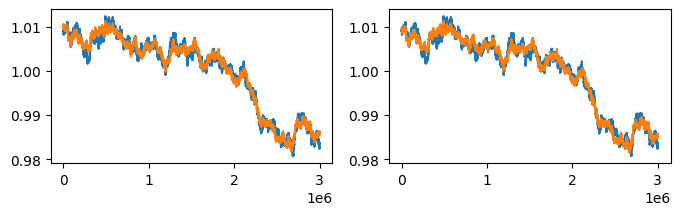

In [336]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].plot(gift / gift.mean())
ax[0].plot(comp / comp.mean())
ax[1].plot(gift / gift.mean())
ax[1].plot(comp_base / comp_base.mean())
plt.show()

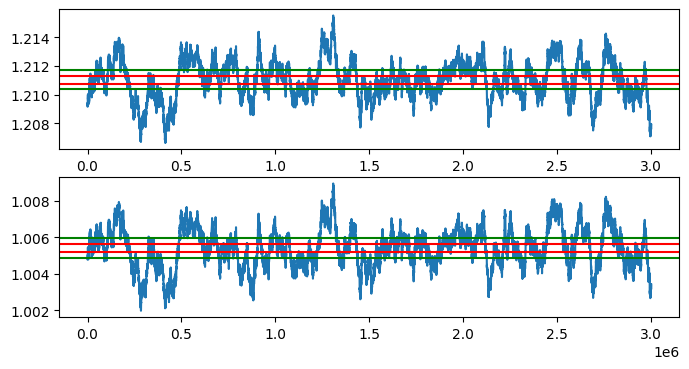

In [337]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(ratio)
ax[0].axhline(ratio.mean() + 0.2 * ratio.std(), c='r')
ax[0].axhline(ratio.mean() - 0.2 * ratio.std(), c='r')
ax[0].axhline(ratio.mean() + 0.5 * ratio.std(), c='g')
ax[0].axhline(ratio.mean() - 0.5 * ratio.std(), c='g')
ax[1].plot(ratio_base)
ax[1].axhline(ratio_base.mean() + 0.2 * ratio_base.std(), c='r')
ax[1].axhline(ratio_base.mean() - 0.2 * ratio_base.std(), c='r')
ax[1].axhline(ratio_base.mean() + 0.5 * ratio_base.std(), c='g')
ax[1].axhline(ratio_base.mean() - 0.5 * ratio_base.std(), c='g')
plt.show()

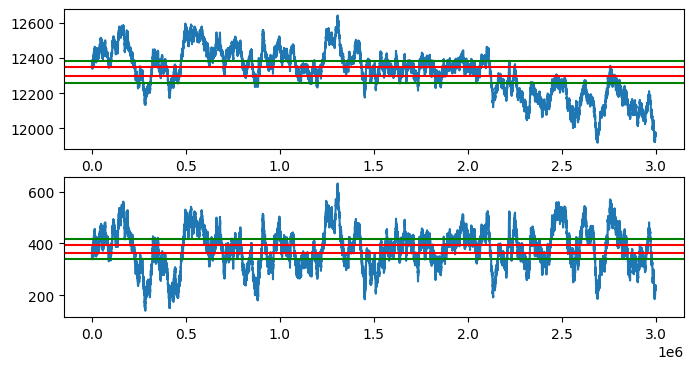

In [338]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(spread)
ax[0].axhline(spread.mean() + 0.2 * spread.std(), c='r')
ax[0].axhline(spread.mean() - 0.2 * spread.std(), c='r')
ax[0].axhline(spread.mean() + 0.5 * spread.std(), c='g')
ax[0].axhline(spread.mean() - 0.5 * spread.std(), c='g')
ax[1].plot(spread_base)
ax[1].axhline(spread_base.mean() + 0.2 * spread_base.std(), c='r')
ax[1].axhline(spread_base.mean() - 0.2 * spread_base.std(), c='r')
ax[1].axhline(spread_base.mean() + 0.5 * spread_base.std(), c='g')
ax[1].axhline(spread_base.mean() - 0.5 * spread_base.std(), c='g')
plt.show()

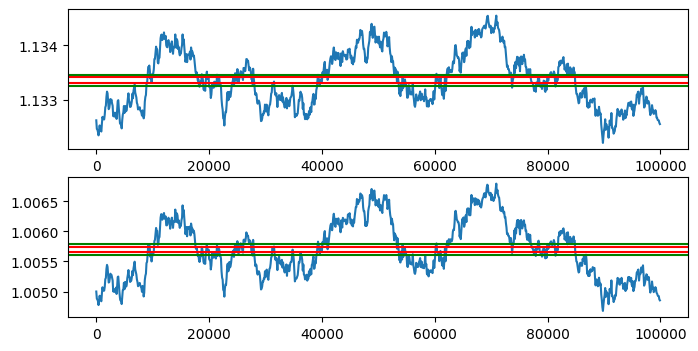

In [316]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(ratio.iloc[:1000])
ax[0].axhline(ratio.iloc[:1000].mean() + 0.1 * ratio.iloc[:1000].std(), c='r')
ax[0].axhline(ratio.iloc[:1000].mean() - 0.1 * ratio.iloc[:1000].std(), c='r')
ax[0].axhline(ratio.iloc[:1000].mean() + 0.2 * ratio.iloc[:1000].std(), c='g')
ax[0].axhline(ratio.iloc[:1000].mean() - 0.2 * ratio.iloc[:1000].std(), c='g')
ax[1].plot(ratio_base.iloc[:1000])
ax[1].axhline(ratio_base.iloc[:1000].mean() + 0.1 * ratio_base.iloc[:1000].std(), c='r')
ax[1].axhline(ratio_base.iloc[:1000].mean() - 0.1 * ratio_base.iloc[:1000].std(), c='r')
ax[1].axhline(ratio_base.iloc[:1000].mean() + 0.2 * ratio_base.iloc[:1000].std(), c='g')
ax[1].axhline(ratio_base.iloc[:1000].mean() - 0.2 * ratio_base.iloc[:1000].std(), c='g')
plt.show()